# The model

The Bayesian model implemented here is based on the model presented in ([De Simone, A. 2020.](https://doi.org/10.1016/j.chaos.2020.110167)). It treats all observations and parameters as random variables. The probability distribution for the effective reproduction number $R_t$ is given by $P_R(r)$. It is a function of the observed occurrence of new cases $I(t)$ and the occurrence of new undetected cases $U(t)$ on a given day $t$. However, in this first attempt, we do not consider the number of undetected cases, and here is the first assumption embeded in the model: The total number of new cases is equal to the number of registered cases. Denoting the total number of new cases on a given day $t$ as $T(t)$, we are assuming $T(t) = I(t)$.

In reality the total number of new cases $T(t)$ is the sum of reported and unreported cases $T(t) = I(t) + U(t)$. In this future framework, there is a dependency of $U(t)$ with $I(t)$, therefore $U(t)$ is a conditional variable $U(t|I(t))$. Another factor that must be considered is the serial interval, given by $P_W(w)$ which provides the probability of a secondary case arising $w$ time steps after a primary case. It is measured by tracking the chain of cases in a population and measuring the time between the onset of symptons on the first case and the onset of symptons on the second case.

By the Bayes theorem, at any time $t$, the posterior probability distribution of $R_t$, given the serial interval distribution, the incidence of new cases history and the undetected cases between $t-\tau$ and $t$ is

\begin{align}
    P_R(r|i_{t < \tau}, (i+u)_{[t - \tau, t]},w) \propto P_R(r) \prod_{k = t - \tau}^t P_{T_k}(i_k| i_{t < k}, w, r)
\end{align}

Where $t < \tau$ referes to the value of a variable before the time $\tau$, and $[t-\tau, t]$ is the value of a variable bewtween the interval $t-\tau$ and $t$. Notice that in this model, the serial interval and the effective reproduction number are assumed to be independent of each other. This posterior probability for $R_t$ is in terms only of known quantities (the serial interval and the incidence of new reported cases). The prior distribution for the effective reproduction number $P_R(r)$ is also given by a uniform distribution $\mathcal{U}(0, 10)$. A more realistic distribution might be estimated if one considers current estimates for the effective reproduction number from other methods. However, it is not in our interest to build a model that relies in some sense on other models for estimating $R_t$, thus we choose to work with a non informative uniform distribution.

From analysis in confirmed cases and epidemiological data in Lombardy, Italy, the serial interval is distributed according to a Gamma distribution described by two parameters: the shape parameter $\alpha_0 = 1.87 \pm 0.26$ and the rate parameter $\beta_0 = 0.28 \pm 0.04$ ([Cereda, D. 2020.](https://arxiv.org/abs/2003.09320)). However, the presence of the gamma function $\Gamma(x)$ in the Gamma distribution leads to a substantial increase in computation time and we decided not to proceed with this distribution. Instead we used a Weibull distribution

\begin{align}
    P_W(w, \alpha_1, \beta_1) = \frac{\beta_1}{\alpha_1} \left(\frac{w}{\alpha_1}\right)^{\beta_1 - 1} e^{-(x/\alpha_1)^{\beta_1}}
\end{align}

where $\alpha_1 = 1.492 \pm 0.112$ and $\beta_1 = 7.024 \pm 0.009$. This parameters were calculated by fitting a Weibull distribution to a Gamma distribution of parameters $\alpha_0$ and $\beta_0$, in order to extract the parameters that make the Weibull distribution the closest to the Gamma distribution, resulting in no loss for the shape of the probability distribution for the serial interval, but saving computational resources. Therefore the prior distribution for $\alpha$ and $\beta$ are given by normal distributions centered at the point estimates and with width $\sigma$ equal to the 1$\sigma$ error, $\alpha \sim \mathcal{N}(1.492, 0.112)$ and $\beta \sim \mathcal{N}(7.024, 0.009)$.

The final variable left to discuss is the number of total new cases $T$ at a instant $k$, given the previous incidence data, the serial interval and the value of $R_t$. We model it as a Poisson distribution with parameter $R \lambda_k$.

\begin{align}
    \lambda_k = \sum_{s=1}^k i_{k-s} \int_{s-\frac{1}{2}}^{s + \frac{1}{2}} P_W(w) \mathrm{d}w
\end{align}

If we consider the reported cases as a representative sample of the population of cases, the serial interval is indeed independent of the unreported cases. Therefore, the final probability distribution for the total incidence of new cases is

\begin{align}
    P_{T_k}(i_k| i_{t < k}, w, r) = e^{r \lambda_k} \frac{\left( r \lambda_k \right)^{i_k}}{i_k!}
\end{align}

We are finally in position to compute the joint posterior probability for $R_t$

\begin{align}
    & P_R(r|\alpha,\beta, i_{[t - \tau, t]},w) \propto P_R(r) \prod_{k = t - \tau}^t e^{r \lambda_k} \frac{\left( r \lambda_k \right)^{i_k}}{i_k!} \Rightarrow \\
    & P_R(r|i_{t < \tau}, i_{[t - \tau, t]},w) \propto P_R(r) \iint P(\alpha_1) P(\beta_1) \prod_{k = t - \tau}^t e^{r \lambda_k} \frac{\left( r \lambda_k \right)^{i_k}}{i_k!} \mathrm{d}\alpha_1 \mathrm{d} \beta_1
\end{align}

Where in the last step we are marginalizing over the parameters $\alpha_1$ and $\beta_1$, in order to obtain the distribution only in terms of $I$ and $w$. This is the probability distribution computed numerically for the incidence of cases registered, from which we evaluate $R_t$

Overall, the assumptions taken into this model are:

- The total number of cases is only given in terms of the reported cases;
- The serial interval is independent of the effective reproduction number;
- The sample of secondary infections measured by reported cases is a representative sample of the total population of secondary infections, in such a way that the serial interval is the same for both reported and undetected cases.

In [339]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# from math import gamma
from scipy.integrate import simps
# from scipy.special import gammaincc
from tqdm import tqdm
from numba import njit
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from random import choices
import datetime
import matplotlib.image as mpimg

In [257]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Importing data
df = pd.read_csv('Vigilância_epidemiologica_CECOM.csv')
df.head(5)

,Data,Notificados,Confirmados,Descartados,Em acompanhamento,Obitos,Investigação (48h)
0,29/11/2021,13873,2585,11047,1,0,NaN
1,30/11/2021,13898,2585,11052,1,0,NaN
2,01/12/2021,13941,2585,11097,1,0,NaN
3,02/12/2021,13970,2586,11129,1,0,NaN
4,03/12/2021,13998,2586,11159,1,0,NaN


In [3]:
df['Novos casos'] = np.concatenate(([0],df['Confirmados'][1:].values - df['Confirmados'][:len(df)-1].values))
new_cases = df['Novos casos'].values

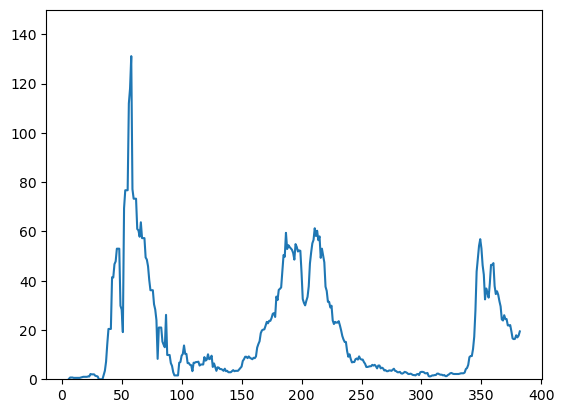

In [5]:
# Plotting the weekly moving average of new cases
plt.plot(pd.DataFrame(new_cases).rolling(7).mean())
plt.ylim(0, 150)
plt.show()

In [37]:
# Defining the probability distribution functions and the integration function
@njit
def poisson(x, k):
    if x == 0:
        factorial = 1
    else:
        factorial = gamma(x)
    f = k**x * np.exp(-k) / factorial
    return f

@njit
def gamma_pdf(x, alpha, beta):
    f = beta**alpha * x**(alpha - 1) * np.exp(-beta * x) / gamma(alpha)
    return f

@njit
def weibull(x, k, l):
    f = (k/l) * (x/l)**(k-1) * np.exp(-(x/l)**k)
    return f

@njit
def integrate(x, y):
    s = 0
    for i in range(len(x)-1):
        dx = x[i+1] - x[i]
        h = np.abs(y[i+1] - y[i])
        s += dx*y[i] + dx*h/2
    return s

@njit
def uniform(x, a, b):
    out = []
    for i in range(len(x)):
        if a <= x[i] <= b:
            out.append(1/(b-a))
        else:
            out.append(0)
    out = np.array(out)
    return out

In [215]:
%%timeit
x = np.linspace(2-0.5, 2+0.5, 100)
simps(st.gamma.pdf(x, a = 1.87, scale = 1/0.28), x)

219 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [216]:
%%timeit
samps = np.random.gamma(1.87, 1/0.28, 10000)
((samps >= 1.5) & (samps <= 2.5)).mean()

702 µs ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


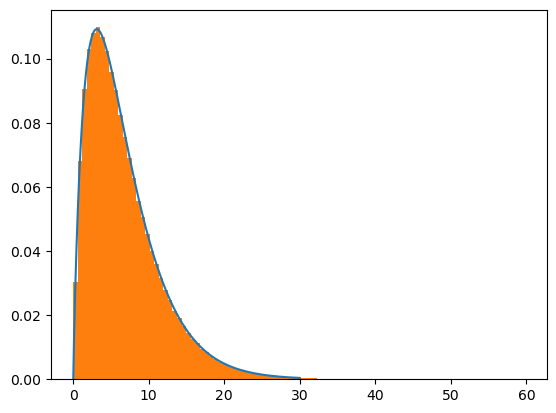

In [46]:
xtndgn = np.linspace(0, 30, 1000)
samps = np.random.gamma(1.87, 1/0.28, 1000000)

plt.plot(xtndgn, st.gamma.pdf(xtndgn, a = 1.87, scale = 1/0.28))
plt.hist(samps, density = True, bins = 100)
plt.show()

In [47]:
c, cov = curve_fit(weibull, xtndgn, st.gamma.pdf(xtndgn, a = 1.87+0.26, scale = 1/(0.28+0.04)), p0 = (2, 4))

In [48]:
c

array([1.60484154, 7.03327244])

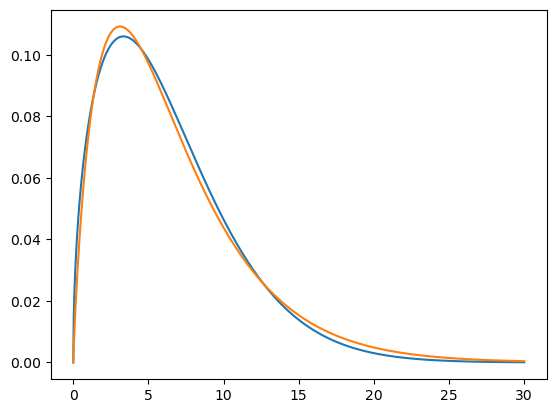

In [262]:
plt.plot(xtndgn, weibull(xtndgn, *c))
plt.plot(xtndgn, st.gamma.pdf(xtndgn, a = 1.87, scale = 1/0.28))
plt.show()

In [49]:
@njit
def integral_w(r, cases, tau, t, n_samples):
    """
    r = reproduction number
    i = reported cases
    tau = interval
    t = time we wish to evaluate
    n_samples = number of samples
    """
    P_r = uniform(r, 0, 10)
    R_s = np.zeros(len(r))
    for i in range(len(r)):
        P_alpha = np.random.normal(1.492, 1.604-1.492, n_samples)
        P_beta = np.random.normal(7.024, 7.033-7.024, n_samples)
        # P_delta = np.random.uniform(0, 2, n_samples)
        prob = 0
        for j in range(n_samples):
            # samps = np.random.gamma(P_alpha[j], P_beta[j], 100000)
            prod = 1
            for k in range(t-tau, t):
                lambd = 0
                for s in range(1,tau):
                    x = np.linspace(s-0.5, s+0.5, 100)
                    lambd += cases[k-s]*integrate(x, weibull(x, P_alpha[j], P_beta[j]))#simps(gamma_pdf(x, P_alpha[j], P_beta[j]), x)
                
                poss = poisson(cases[k], r[i]*lambd)
                # print(poss)
                # Q1 = gammaincc((1+P_delta[j])*cases[l] + 1, r[i]*lambd)
                # Q2 = gammaincc(cases[l], r[i]*lambd)
                
                prod *= poss#Q2# - Q2
            
            prob += P_r[i]*prod
        R_s[i] = prob/n_samples
    return R_s/integrate(r, R_s)

In [39]:
y = np.round(pd.DataFrame(new_cases).rolling(7).mean().dropna().values.flatten(), 0)
len(y)

377

In [52]:
r = np.linspace(0.1, 10, 100)
post = integral_w(r, y, 7, 370, 1000)

In [54]:
%%timeit
post = integral_w(r, y, 7, 370, 100)

6.7 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
post = integral_w(r, y, 14, 370, 100)

30.6 s ± 906 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
post = integral_w(r, y, 7, 370, 1000)

1min 7s ± 3.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%%timeit
post = integral_w(r, y, 10, 370, 100)

11.6 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
post = integral_w(r, y, 10, 370, 100)

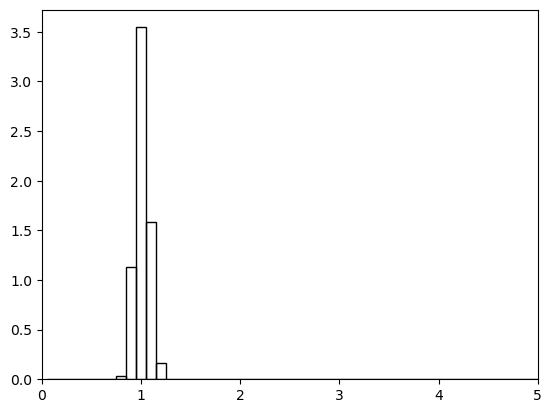

In [73]:
plt.bar(r, post, fill = False, width = 0.1)
# plt.yscale('log')
plt.xlim(0, 5)
plt.show()

In [144]:
r = np.arange(0.1, 10.05, 0.05)

posts2 = []
for i in tqdm(range(len(y)-100)):
    posts2.append(integral_w(r, y, 10, i, 500))
    
posts2 = np.array(posts2)

100%|██████████| 277/277 [9:02:43<00:00, 117.56s/it]  


In [230]:
low_95ci = []
up_95ci = []
maximum = []
mean = []

xnew = np.linspace(0.1, 10, 100000)

for i in tqdm(range(len(posts2))):
    f = interp1d(r, posts2[i,:], kind = 'cubic')
    samples = choices(xnew, f(xnew), k = 1000000)
    low_95ci.append(np.percentile(samples, 2.5))
    up_95ci.append(np.percentile(samples, 97.5))
    maximum.append(xnew[np.argmax(f(xnew))])
    mean.append(np.mean(samples))
    if i == len(posts2)-1:
        prob_below_1 = (np.array(samples) <= 1).sum()/len(samples)

100%|██████████| 277/277 [06:56<00:00,  1.50s/it]


In [272]:
prob_below_1 = (np.array(samples) <= 1).sum()/len(samples)

In [335]:
numdays = len(posts2)+3
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]

In [336]:
date_list.reverse()

In [337]:
dates = [str(date_list[i]).split(' ')[0] for i in range(len(date_list)-3)]

In [340]:
im = mpimg.imread(r"UNICAMP_logo.png")

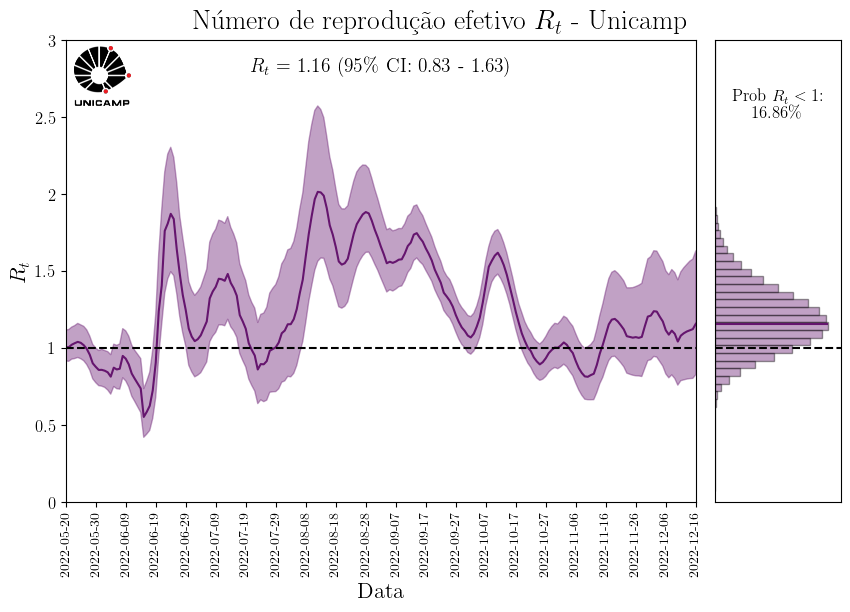

In [349]:
fig, ax = plt.subplots(1, 2, figsize = (10,6), gridspec_kw={"width_ratios": [5, 1], "wspace": 0.05})

ax[0].plot([i for i in range(len(y)-100)], maximum,
        color = sns.color_palette('inferno')[1])
ax[0].fill_between([i for i in range(len(y)-100)], low_95ci, up_95ci,
        color = sns.color_palette('inferno')[1], alpha = 0.4)
ax[0].set_xlim(66,276)
ax[0].set_ylim(0,3)
ax[0].axhline(1, ls = '--', color = 'black')
ax[0].text((ax[0].get_xlim()[1]+ax[0].get_xlim()[0])/2, 2.8,
           r'$R_t$ = ' + f'{maximum[-1]:.2f} (95\% CI: {low_95ci[-1]:.2f} - {up_95ci[-1]:.2f})', fontsize = 14, ha = 'center')
ax[0].set_yticks([0,0.5,1,1.5,2,2.5,3])
ax[0].set_yticklabels([0,0.5,1,1.5,2,2.5,3], fontsize = 12)
ax[0].set_xticks(np.arange(ax[0].get_xlim()[0], ax[0].get_xlim()[1]+1, 10))
ax[0].set_xticklabels([dates[int(ax[0].get_xticks()[i])] for i in range(len(ax[0].get_xticks()))],
                      rotation = 90)
ax[0].set_ylabel(r'$R_t$', fontsize = 16)
ax[0].set_xlabel('Data', fontsize = 16)

ax[1].barh(r, posts2[-1,:], edgecolor = 'black', height = r[1]-r[0],
          color = sns.color_palette('inferno')[1], alpha = 0.4)
ax[1].set_ylim(0, 3)
ax[1].set_yticks([])
ax[1].set_xlim(0, 2)
ax[1].set_xticks([])
ax[1].hlines(maximum[-1], 0, np.max(posts2[-1,:]), color = sns.color_palette('inferno')[1])
ax[1].axhline(1, ls = '--', color = 'black')
ax[1].text(1, 2.5, r'Prob $R_t < 1$:' + '\n' + f'{100*prob_below_1:.2f}\%', fontsize = 12, ha = 'center')

fig.text(0.5, 0.9, r'Número de reprodução efetivo $R_t$ - Unicamp', fontsize = 20, ha = 'center')

newax = fig.add_axes([0.09,0.77,0.10,0.10], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')
plt.savefig('Rt_calculus_unicamp.png', dpi = 300, bbox_inches = 'tight')
plt.show()

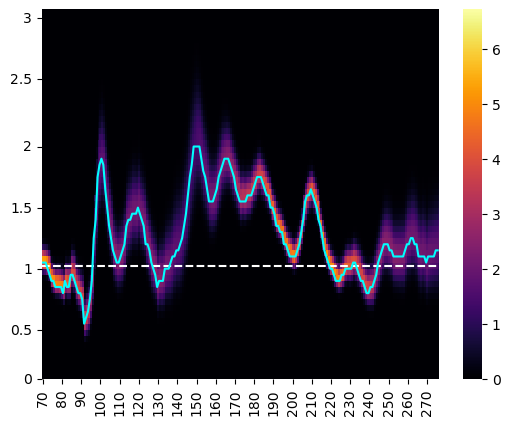

In [169]:
ax = sns.heatmap(posts2.T, cmap = 'inferno')
ax.invert_yaxis()
plt.xlim(70, 276.5)
plt.ylim(0, 60.5)
plt.yticks([0,8,18,28,38,49,59], labels = [0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.axhline(18.5, color = 'white', ls = '--')
plt.plot([i for i in range(len(y)-100)], np.argmax(posts2, axis = 1),
        color = 'cyan')
plt.show()